# M-PHATE Demonstration
## Autoencoder (keras)

In this notebook, we demonstrate the use of M-PHATE to visualize the evolution of a simple 3-layer autoencoder over the course of training.

### 1. Setup

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

import keras
import scprep

import m_phate
import m_phate.train
import m_phate.data

Using TensorFlow backend.


Let's set the session so we can limit what percentage of the GPU is used, for courtesy's sake.

In [2]:
keras.backend.set_session(tf.Session(config=m_phate.train.build_config(limit_gpu_fraction=0.2)))

Now we load MNIST in preprocessed form.

In [3]:
x_train, x_test, y_train, y_test = m_phate.data.load_mnist()

### 2. Build the neural network

In [4]:
# leaky relu activation function
lrelu = keras.layers.LeakyReLU(alpha=0.1)

# input layer
inputs = keras.layers.Input(
    shape=(x_train.shape[1],), dtype='float32', name='inputs')

# three dense hidden layers
h1 = keras.layers.Dense(64, name='h1')(inputs)
h2 = keras.layers.Dense(64, name='h2')(lrelu(h1))
h3 = keras.layers.Dense(64, name='h3')(lrelu(h2))

# output layer
outputs = keras.layers.Dense(
    x_train.shape[1], activation='softmax', name='output_all')((lrelu(h3)))

Instructions for updating:
Colocations handled automatically by placer.


Wow, that was easy.

### 3. Set up the neural network trace

Here we randomly select ten examples of every digit from the test set - the hidden activations of these images will form our data tensor to be visualized.

In [5]:
np.random.seed(42)
# select the digit indices in the test set
trace_idx = []
for i in range(10):
    trace_idx.append(np.random.choice(np.argwhere(
        y_test[:, i] == 1).flatten(), 10, replace=False))

trace_idx = np.concatenate(trace_idx)
# extract the selected images
trace_data = x_test[trace_idx]

# build a keras model which outputs the hidden activations
model_trace = keras.models.Model(inputs=inputs, outputs=[h1, h2, h3])
# use the TraceHistory helper class to store the outputs at each epoch
trace = m_phate.train.TraceHistory(trace_data, model_trace)

### 4. Train the network

In [6]:
# create another callback to store loss, accuracy etc
history = keras.callbacks.History()

# compile the model
optimizer = keras.optimizers.Adam(lr=1e-5)
model = keras.models.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=optimizer, loss='mean_squared_error',
              metrics=['mean_squared_error', 'binary_crossentropy'])

# train!
model.fit(x_train, x_train,
          batch_size=128, epochs=200,
          verbose=0, callbacks=[trace, history],
          validation_data=(x_test,
                           x_test))

Instructions for updating:
Use tf.cast instead.


### 5. Retrieve the output

There are a lot of metadata features we might be interested in visualizing, so we show you all of them here.

The most important element here is the first: the `n_epochs x n_neurons x n_examples` tensor. We often refer to the _flattened tensor_ as this is what will be returned by M-PHATE: this is the `n_epochs*n_neurons x n_dim` matrix to be visualized.

In [7]:
# the actual data tensor
trace_data = np.array(trace.trace)
n_epochs = trace_data.shape[0]
n_neurons = trace_data.shape[1]

# the train loss for each element of the flattened trace
loss = np.repeat(history.history['mean_squared_error'], n_neurons)
# the validation loss for each element of the flattened trace
val_loss = np.repeat(history.history['val_mean_squared_error'], n_neurons)
# the train cross entropy for each element of the flattened trace
entropy = np.repeat(history.history['binary_crossentropy'], n_neurons)
# the validation cross entropy for each element of the flattened trace
val_entropy = np.repeat(history.history['val_binary_crossentropy'], n_neurons)

# the unique neuron id for each element of the flattened trace
neuron_ids = np.tile(np.arange(n_neurons), n_epochs)
# the hidden layer that each element of the flattened trace belongs to
layer_ids = np.tile(np.concatenate([np.repeat(i, int(layer.shape[1]))
                                    for i, layer in enumerate(model_trace.outputs)]),
                    n_epochs)
# the current epoch for each element of the flattened trace
epoch = np.repeat(np.arange(n_epochs), n_neurons)

# the label of each digit we selected: this should be the same as `np.repeat(np.arange(10), 10)`
digit_ids = y_test.argmax(1)[trace_idx]
# the average activity over digit labels for each element of the flattened trace
digit_activity = np.array([np.sum(np.abs(trace_data[:, :, digit_ids == digit]), axis=2)
                           for digit in np.unique(digit_ids)])
# the digit label with the highest average activity for each element of the flattened trace
most_active_digit = np.argmax(digit_activity, axis=0).flatten()

### 6. Visualize the data tensor

Calculating PHATE...
  Calculating M-PHATE...
    Calculating multislice kernel...
    Calculated multislice kernel in 8.81 seconds.
    Calculating graph and diffusion operator...
      Calculating landmark operator...
        Calculating SVD...
        Calculated SVD in 9.63 seconds.
        Calculating KMeans...
        Calculated KMeans in 71.94 seconds.
      Calculated landmark operator in 86.31 seconds.
    Calculated graph and diffusion operator in 86.94 seconds.
    Running PHATE on precomputed affinity matrix with 200 cells.
  Calculated M-PHATE in 95.78 seconds.
  Calculating optimal t...
    Automatically selected t = 34
  Calculated optimal t in 36.23 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 16.02 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 214.95 seconds.
Calculated PHATE in 363.00 seconds.


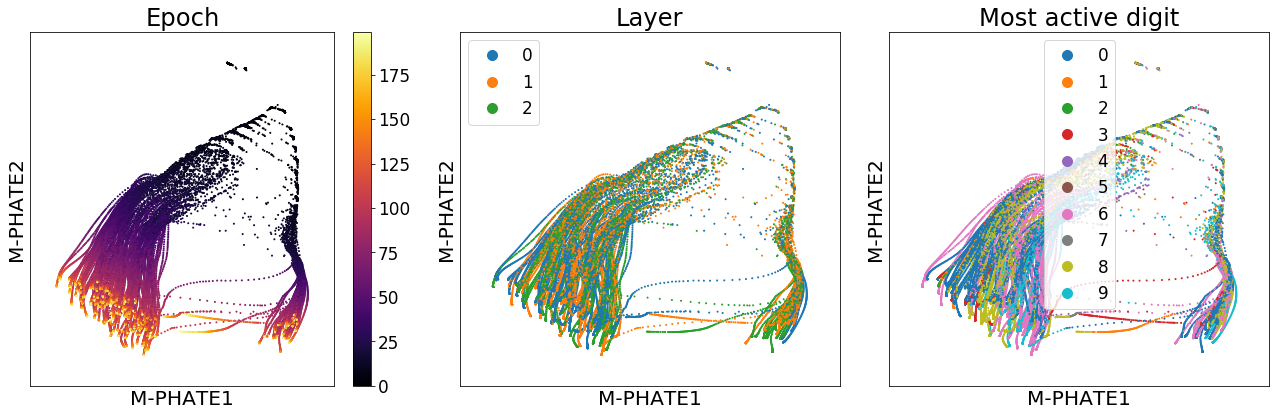

In [8]:
# calculate M-PHATE
m_phate_op = m_phate.M_PHATE()
m_phate_data = m_phate_op.fit_transform(trace_data)

# plot the results
plt.rc('font', size=14)
fig, (ax1, ax2, ax3) = plt.subplots(
    1, 3, figsize=(18, 6), sharex='all', sharey='all')
scprep.plot.scatter2d(m_phate_data, c=epoch, ax=ax1, ticks=False,
                      title='Epoch', label_prefix="M-PHATE")
scprep.plot.scatter2d(m_phate_data, c=layer_ids, ax=ax2, title='Layer',
                      ticks=False, label_prefix="M-PHATE")
scprep.plot.scatter2d(m_phate_data, c=most_active_digit, ax=ax3,
                      title='Most active digit',
                      ticks=False, label_prefix="M-PHATE")
plt.tight_layout()

In [9]:
# do it in 3D!
m_phate_op.set_params(n_components=3)
m_phate_data = m_phate_op.transform()

# plot the results
scprep.plot.rotate_scatter3d(m_phate_data, c=most_active_digit,
                             title='Most active digit',
                             ticks=False, label_prefix="M-PHATE")

Calculating metric MDS...
Calculated metric MDS in 1407.01 seconds.
